# 基于DNN的电影推荐系统

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf
import os
import pickle
import re
from tensorflow.python.ops import math_ops


In [2]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('C:/Users/tong/Desktop/movies/ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [3]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('C:/Users/tong/Desktop/movies/ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

In [4]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('C:/Users/tong/Desktop/movies/ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 实现数据预处理

In [5]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('C:/Users/tong/Desktop/movies/ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('C:/Users/tong/Desktop/movies/ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)} # 构造得到的字典，字典中某一项是 <PAD>

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('C:/Users/tong/Desktop/movies/ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

# 加载数据并保存到本地
- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [6]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: read_table is deprecated, use read_csv instead.


In [7]:
#预处理后的数据
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [8]:
movies.head()

,MovieID,Title,Genres
0,1,"[3911, 2390, 4315, 4315, 4315, 4315, 4315, 431...","[10, 3, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
1,2,"[4616, 4315, 4315, 4315, 4315, 4315, 4315, 431...","[14, 3, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
2,3,"[2035, 2513, 288, 4315, 4315, 4315, 4315, 4315...","[16, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
3,4,"[633, 2625, 3758, 4315, 4315, 4315, 4315, 4315...","[16, 5, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
4,5,"[1718, 3323, 4284, 74, 3387, 3124, 4315, 4315,...","[16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."


In [9]:
movies.values[0]

array([1,
       list([3911, 2390, 4315, 4315, 4315, 4315, 4315, 4315, 4315, 4315, 4315, 4315, 4315, 4315, 4315]),
       list([10, 3, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
      dtype=object)

In [10]:
#从本地读取数据
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

In [11]:
#辅助函数
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


In [12]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [13]:
#超参
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

In [14]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

# 构建神经网络

In [15]:
#定义user的嵌入矩阵
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [16]:
#将User的嵌入矩阵一起全连接生成User的特征
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [17]:
#定义Movie ID的嵌入矩阵
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [18]:
#对电影类型的多个嵌入向量做加和
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

In [19]:
#Movie Title的文本卷积网络实现
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [20]:
#将Movie的各个层一起做全连接
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

# 构建计算图

In [21]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

In [23]:
#取得batch
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [24]:
#训练网络
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


Writing to C:\Users\tong\Desktop\movies\project\test1\runs\1578196854

2020-01-05T12:01:09.972912: Epoch   0 Batch    0/3125   train_loss = 7.744
2020-01-05T12:01:12.097199: Epoch   0 Batch   20/3125   train_loss = 3.255
2020-01-05T12:01:14.219119: Epoch   0 Batch   40/3125   train_loss = 2.171
2020-01-05T12:01:16.147935: Epoch   0 Batch   60/3125   train_loss = 1.623
2020-01-05T12:01:18.155368: Epoch   0 Batch   80/3125   train_loss = 1.578
2020-01-05T12:01:20.266315: Epoch   0 Batch  100/3125   train_loss = 1.613
2020-01-05T12:01:22.161861: Epoch   0 Batch  120/3125   train_loss = 1.638
2020-01-05T12:01:24.022462: Epoch   0 Batch  140/3125   train_loss = 1.649
2020-01-05T12:01:25.955923: Epoch   0 Batch  160/3125   train_loss = 1.356
2020-01-05T12:01:27.691252: Epoch   0 Batch  180/3125   train_loss = 1.358
2020-01-05T12:01:28.660706: Epoch   0 Batch  200/3125   train_loss = 1.654
2020-01-05T12:01:29.585818: Epoch   0 Batch  220/3125   train_loss = 1.564
2020-01-05T12:01:30.499620: E

2020-01-05T12:04:09.468743: Epoch   0 Batch 2180/3125   train_loss = 1.117
2020-01-05T12:04:10.440746: Epoch   0 Batch 2200/3125   train_loss = 1.128
2020-01-05T12:04:11.589648: Epoch   0 Batch 2220/3125   train_loss = 1.102
2020-01-05T12:04:13.384415: Epoch   0 Batch 2240/3125   train_loss = 1.020
2020-01-05T12:04:15.334891: Epoch   0 Batch 2260/3125   train_loss = 1.032
2020-01-05T12:04:17.148193: Epoch   0 Batch 2280/3125   train_loss = 1.205
2020-01-05T12:04:18.940686: Epoch   0 Batch 2300/3125   train_loss = 1.143
2020-01-05T12:04:20.847825: Epoch   0 Batch 2320/3125   train_loss = 1.329
2020-01-05T12:04:22.727704: Epoch   0 Batch 2340/3125   train_loss = 1.140
2020-01-05T12:04:24.582333: Epoch   0 Batch 2360/3125   train_loss = 1.123
2020-01-05T12:04:26.485123: Epoch   0 Batch 2380/3125   train_loss = 1.151
2020-01-05T12:04:28.363932: Epoch   0 Batch 2400/3125   train_loss = 1.230
2020-01-05T12:04:29.264523: Epoch   0 Batch 2420/3125   train_loss = 1.084
2020-01-05T12:04:30.47357

2020-01-05T12:06:29.305736: Epoch   1 Batch  475/3125   train_loss = 1.149
2020-01-05T12:06:31.348620: Epoch   1 Batch  495/3125   train_loss = 1.008
2020-01-05T12:06:32.383368: Epoch   1 Batch  515/3125   train_loss = 1.101
2020-01-05T12:06:33.666846: Epoch   1 Batch  535/3125   train_loss = 1.154
2020-01-05T12:06:35.678325: Epoch   1 Batch  555/3125   train_loss = 1.197
2020-01-05T12:06:37.643665: Epoch   1 Batch  575/3125   train_loss = 1.108
2020-01-05T12:06:38.675484: Epoch   1 Batch  595/3125   train_loss = 1.293
2020-01-05T12:06:39.694502: Epoch   1 Batch  615/3125   train_loss = 1.051
2020-01-05T12:06:41.903032: Epoch   1 Batch  635/3125   train_loss = 1.100
2020-01-05T12:06:44.054225: Epoch   1 Batch  655/3125   train_loss = 0.972
2020-01-05T12:06:46.625976: Epoch   1 Batch  675/3125   train_loss = 0.865
2020-01-05T12:06:48.944289: Epoch   1 Batch  695/3125   train_loss = 1.036
2020-01-05T12:06:50.948053: Epoch   1 Batch  715/3125   train_loss = 1.160
2020-01-05T12:06:53.12977

2020-01-05T12:09:42.504714: Epoch   1 Batch 2675/3125   train_loss = 0.961
2020-01-05T12:09:44.387540: Epoch   1 Batch 2695/3125   train_loss = 0.992
2020-01-05T12:09:46.391922: Epoch   1 Batch 2715/3125   train_loss = 0.970
2020-01-05T12:09:48.297191: Epoch   1 Batch 2735/3125   train_loss = 0.847
2020-01-05T12:09:49.847119: Epoch   1 Batch 2755/3125   train_loss = 1.072
2020-01-05T12:09:50.773640: Epoch   1 Batch 2775/3125   train_loss = 1.032
2020-01-05T12:09:52.315337: Epoch   1 Batch 2795/3125   train_loss = 1.061
2020-01-05T12:09:54.486308: Epoch   1 Batch 2815/3125   train_loss = 0.983
2020-01-05T12:09:56.483521: Epoch   1 Batch 2835/3125   train_loss = 1.025
2020-01-05T12:09:58.608032: Epoch   1 Batch 2855/3125   train_loss = 1.049
2020-01-05T12:10:00.686172: Epoch   1 Batch 2875/3125   train_loss = 0.969
2020-01-05T12:10:02.683937: Epoch   1 Batch 2895/3125   train_loss = 0.991
2020-01-05T12:10:04.784850: Epoch   1 Batch 2915/3125   train_loss = 0.884
2020-01-05T12:10:06.74543

2020-01-05T12:11:57.207829: Epoch   2 Batch  990/3125   train_loss = 0.933
2020-01-05T12:11:59.081325: Epoch   2 Batch 1010/3125   train_loss = 1.120
2020-01-05T12:12:00.743173: Epoch   2 Batch 1030/3125   train_loss = 0.944
2020-01-05T12:12:01.675330: Epoch   2 Batch 1050/3125   train_loss = 0.916
2020-01-05T12:12:03.038459: Epoch   2 Batch 1070/3125   train_loss = 1.016
2020-01-05T12:12:05.016534: Epoch   2 Batch 1090/3125   train_loss = 1.115
2020-01-05T12:12:06.971855: Epoch   2 Batch 1110/3125   train_loss = 1.057
2020-01-05T12:12:09.097581: Epoch   2 Batch 1130/3125   train_loss = 0.929
2020-01-05T12:12:11.128258: Epoch   2 Batch 1150/3125   train_loss = 0.989
2020-01-05T12:12:13.097074: Epoch   2 Batch 1170/3125   train_loss = 1.000
2020-01-05T12:12:14.809887: Epoch   2 Batch 1190/3125   train_loss = 1.004
2020-01-05T12:12:15.826000: Epoch   2 Batch 1210/3125   train_loss = 0.910
2020-01-05T12:12:17.504562: Epoch   2 Batch 1230/3125   train_loss = 0.822
2020-01-05T12:12:19.39442

2020-01-05T12:14:55.530344: Epoch   2 Batch   78/781   test_loss = 0.877
2020-01-05T12:14:55.907426: Epoch   2 Batch   98/781   test_loss = 0.937
2020-01-05T12:14:56.263292: Epoch   2 Batch  118/781   test_loss = 0.823
2020-01-05T12:14:56.583435: Epoch   2 Batch  138/781   test_loss = 0.972
2020-01-05T12:14:56.879196: Epoch   2 Batch  158/781   test_loss = 0.858
2020-01-05T12:14:57.177427: Epoch   2 Batch  178/781   test_loss = 0.827
2020-01-05T12:14:57.515495: Epoch   2 Batch  198/781   test_loss = 0.905
2020-01-05T12:14:57.829692: Epoch   2 Batch  218/781   test_loss = 1.006
2020-01-05T12:14:58.176533: Epoch   2 Batch  238/781   test_loss = 0.922
2020-01-05T12:14:58.541494: Epoch   2 Batch  258/781   test_loss = 0.974
2020-01-05T12:14:58.875977: Epoch   2 Batch  278/781   test_loss = 1.056
2020-01-05T12:14:59.202771: Epoch   2 Batch  298/781   test_loss = 0.885
2020-01-05T12:14:59.539393: Epoch   2 Batch  318/781   test_loss = 0.916
2020-01-05T12:14:59.835601: Epoch   2 Batch  338/78

2020-01-05T12:17:10.979454: Epoch   3 Batch 1505/3125   train_loss = 0.828
2020-01-05T12:17:12.870396: Epoch   3 Batch 1525/3125   train_loss = 0.757
2020-01-05T12:17:14.778793: Epoch   3 Batch 1545/3125   train_loss = 0.873
2020-01-05T12:17:16.731967: Epoch   3 Batch 1565/3125   train_loss = 1.008
2020-01-05T12:17:18.600091: Epoch   3 Batch 1585/3125   train_loss = 0.860
2020-01-05T12:17:19.520664: Epoch   3 Batch 1605/3125   train_loss = 0.892
2020-01-05T12:17:20.718117: Epoch   3 Batch 1625/3125   train_loss = 0.942
2020-01-05T12:17:22.516481: Epoch   3 Batch 1645/3125   train_loss = 1.000
2020-01-05T12:17:24.452936: Epoch   3 Batch 1665/3125   train_loss = 0.954
2020-01-05T12:17:26.325207: Epoch   3 Batch 1685/3125   train_loss = 0.964
2020-01-05T12:17:27.297723: Epoch   3 Batch 1705/3125   train_loss = 0.939
2020-01-05T12:17:28.543987: Epoch   3 Batch 1725/3125   train_loss = 0.871
2020-01-05T12:17:30.436698: Epoch   3 Batch 1745/3125   train_loss = 0.799
2020-01-05T12:17:32.31709

2020-01-05T12:19:30.180799: Epoch   3 Batch  617/781   test_loss = 0.900
2020-01-05T12:19:30.480996: Epoch   3 Batch  637/781   test_loss = 0.845
2020-01-05T12:19:30.788248: Epoch   3 Batch  657/781   test_loss = 1.000
2020-01-05T12:19:31.128631: Epoch   3 Batch  677/781   test_loss = 0.895
2020-01-05T12:19:31.484205: Epoch   3 Batch  697/781   test_loss = 0.944
2020-01-05T12:19:31.805226: Epoch   3 Batch  717/781   test_loss = 0.898
2020-01-05T12:19:32.143403: Epoch   3 Batch  737/781   test_loss = 0.745
2020-01-05T12:19:32.461455: Epoch   3 Batch  757/781   test_loss = 1.005
2020-01-05T12:19:32.809038: Epoch   3 Batch  777/781   test_loss = 0.922
2020-01-05T12:19:33.669477: Epoch   4 Batch    0/3125   train_loss = 0.930
2020-01-05T12:19:35.521085: Epoch   4 Batch   20/3125   train_loss = 0.899
2020-01-05T12:19:36.662070: Epoch   4 Batch   40/3125   train_loss = 0.879
2020-01-05T12:19:37.854397: Epoch   4 Batch   60/3125   train_loss = 0.753
2020-01-05T12:19:39.686773: Epoch   4 Batch

2020-01-05T12:22:14.857039: Epoch   4 Batch 2020/3125   train_loss = 0.923
2020-01-05T12:22:15.769200: Epoch   4 Batch 2040/3125   train_loss = 0.773
2020-01-05T12:22:16.997014: Epoch   4 Batch 2060/3125   train_loss = 0.839
2020-01-05T12:22:18.838933: Epoch   4 Batch 2080/3125   train_loss = 1.003
2020-01-05T12:22:20.672861: Epoch   4 Batch 2100/3125   train_loss = 0.819
2020-01-05T12:22:22.520688: Epoch   4 Batch 2120/3125   train_loss = 0.834
2020-01-05T12:22:24.255831: Epoch   4 Batch 2140/3125   train_loss = 0.857
2020-01-05T12:22:25.176034: Epoch   4 Batch 2160/3125   train_loss = 0.851
2020-01-05T12:22:26.410010: Epoch   4 Batch 2180/3125   train_loss = 0.948
2020-01-05T12:22:28.331724: Epoch   4 Batch 2200/3125   train_loss = 0.821
2020-01-05T12:22:30.261354: Epoch   4 Batch 2220/3125   train_loss = 0.760
2020-01-05T12:22:32.059243: Epoch   4 Batch 2240/3125   train_loss = 0.868
2020-01-05T12:22:32.977846: Epoch   4 Batch 2260/3125   train_loss = 0.853
2020-01-05T12:22:34.38080

In [25]:
#保存参数
save_params((save_dir))

load_dir = load_params()

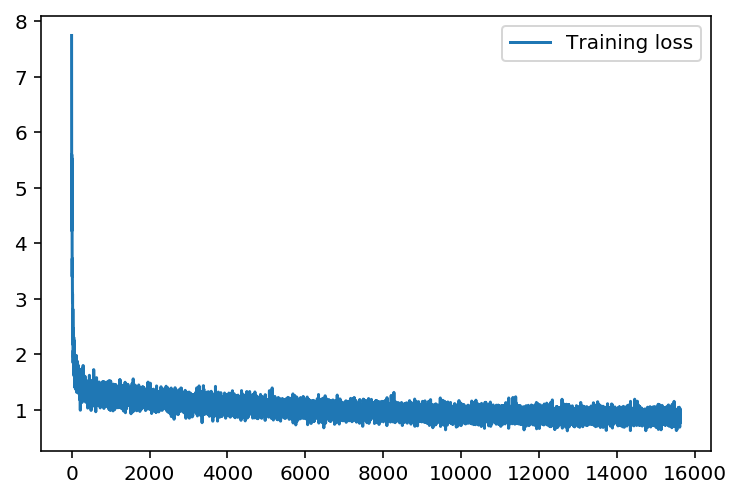

In [26]:
# 显示训练Loss
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

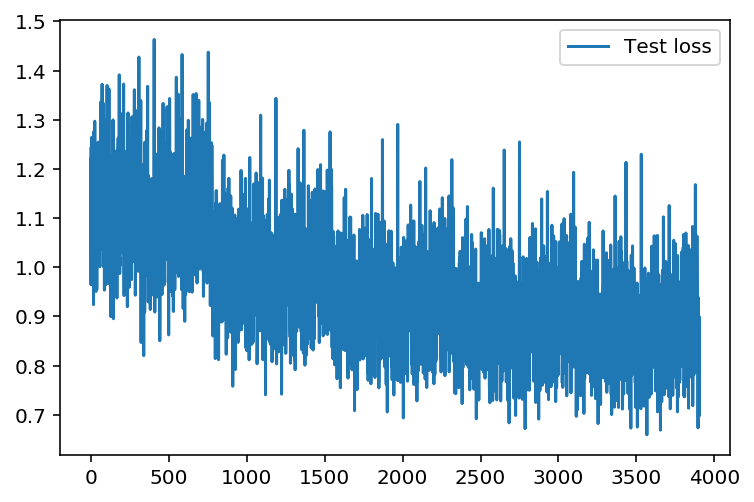

In [27]:
#显示测试Loss
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

# 获取 Tensors
使用函数 get_tensor_by_name()从 loaded_graph 中获取tensors

In [28]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 这里也要修改 感谢网友 @清歌 指出问题
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


# 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [29]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [30]:
rating_movie(234, 1401)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./save


[array([[3.5502954]], dtype=float32)]

# 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [31]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


# 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [33]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [34]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

# 开始推荐电影
使用生成的用户特征矩阵和电影特征矩阵做电影推荐


In [35]:
#推荐同类型的电影 
#思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [36]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
1380
[1401 'Ghosts of Mississippi (1996)' 'Drama']
2541
[2610 'Three Seasons (1999)' 'Drama']
2645
[2714 'Wood, The (1999)' 'Drama']
3418
[3487 'Dorado, El (1967)' 'Western']
2911
[2980 'Men Cry Bullets (1997)' 'Drama']


{1380, 2541, 2645, 2911, 3418}

In [37]:
#推荐您喜欢的电影
#思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results


In [38]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
1189
[1207 'To Kill a Mockingbird (1962)' 'Drama']
3020
[3089 'Bicycle Thief, The (Ladri di biciclette) (1948)' 'Drama']
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
2488
[2557 'I Stand Alone (Seul contre tous) (1998)' 'Drama']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']


{49, 315, 1189, 2488, 3020}

In [39]:
#看过这个电影的人还看了（喜欢）哪些电影
#首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
#然后计算这几个人对所有电影的评分
#选择每个人评分最高的电影作为推荐
#同样加入了随机选择

import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [40]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[5625 'M' 25 1]
 [4757 'M' 35 17]
 [74 'M' 35 14]
 [5113 'M' 25 0]
 [713 'M' 35 7]
 [104 'M' 25 12]
 [100 'M' 35 17]
 [5728 'F' 35 20]
 [1268 'M' 50 2]
 [5567 'M' 50 3]
 [2144 'M' 18 0]
 [161 'M' 45 16]
 [1763 'M' 35 7]
 [3833 'M' 25 1]
 [3800 'M' 18 1]
 [1731 'F' 18 0]
 [1081 'M' 18 4]
 [4085 'F' 25 6]
 [3901 'M' 18 14]
 [2154 'M' 25 12]]
喜欢看这个电影的人还喜欢看：
1131
[1147 'When We Were Kings (1996)' 'Documentary']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
1180
[1198 'Raiders of the Lost Ark (1981)' 'Action|Adventure']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
892
[904 'Rear Window (1954)' 'Mystery|Thriller']


{315, 847, 892, 1131, 1180}